# CNN CIFAR-10

## Imports

In [1]:
import os
import wandb
import torch
import torchvision
import lightning as li
from lightning.pytorch.callbacks import TQDMProgressBar
from lightning.pytorch.loggers import WandbLogger

import matplotlib.pyplot as plt
import numpy as np

In [2]:
print(f"Environment Info")

# Device
print(f" | Device: {os.uname().nodename}")

# GPU Env Info
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")
    print(f" | MPS Device: {mps_device}")

# CPU Env Info
print(f" | CPU Threads: {torch.get_num_threads()}")

Environment Info
 | Device: macbook-pro-von-yvo.home
 | MPS Device: mps
 | CPU Threads: 12


In [3]:
# Initialize Weights & Biases
os.environ['WANDB_NOTEBOOK_NAME'] = 'mini-challenge-1.ipynb'
wandb.login()

wandb: Currently logged in as: yvokeller (sensor-based-activity-recognition). Use `wandb login --relogin` to force relogin


True

# Schritt 1: Auswahl Task / Datensatz 

1. Mache Dir Gedanken, mit welchen Daten Du arbeiten möchtest und welcher Task gelernt werden soll.  
2. Diskutiere die Idee mit dem Fachcoach.  


**Absprache mit Fachcoach**:

- Deadline: 20. April 2023
- Task: Klassifizierung des CIFAR-10 Datensatzes (32x32 Bilder von 10 Klassen)
- Nutzung von W&B zur Model Evaluation
- [Deep Learning Vorlesungen](https://fleuret.org/dlc/) von Francois Fleuret als Grundlage


# Schritt 2: Daten Kennenlernen 
1. Mache Dich mit dem Datensatz vertraut, indem Du eine (kurze) explorative Analyse der Features durchführst: z.B. Vergleich der Klassen pro Feature, Balanciertheit der Klassen. 
2. Führe ein geeignetes Preprocessing durch, z.B. Normalisierung der Daten.

## Load & Preprocess Dataset 

In [41]:
transform = torchvision.transforms.Compose([
    # 1. transform to pytorch Tensor, which also scales the values to [0, 1]
    torchvision.transforms.ToTensor(), 
    # 2. normalize the tensor with mean (0.5, 0.5, 0.5) and standard deviation (0.5, 0.5, 0.5) for each of the three color channels (RGB) of the image
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [57]:
def get_dataloaders(batch_size, shuffle=False):
    train_dataloader = torch.utils.data.DataLoader(
        trainset, 
        batch_size=batch_size, 
        num_workers=9,
        shuffle=shuffle, 
    )

    val_dataloader = torch.utils.data.DataLoader(
        testset,
        batch_size=batch_size, 
        num_workers=3,
        shuffle=shuffle,
    )

    return train_dataloader, val_dataloader

## EDA

### Looking at some images

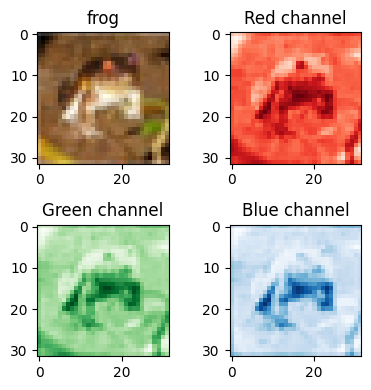

In [28]:
# Plot an image from the dataset
def plot_image(id, dataset):
    img = dataset.data[id]

    fig, axs = plt.subplots(2, 2, figsize=(4, 4))
    axs = axs.flatten()

    axs[0].imshow(img)
    axs[0].set_title(dataset.classes[dataset.targets[id]])

    axs[1].imshow(img[:,:,0], cmap='Reds')
    axs[1].set_title('Red channel')

    axs[2].imshow(img[:,:,1], cmap='Greens')
    axs[2].set_title('Green channel')

    axs[3].imshow(img[:,:,2], cmap='Blues')
    axs[3].set_title('Blue channel')

    plt.tight_layout()
    plt.show()

plot_image(0, trainset)

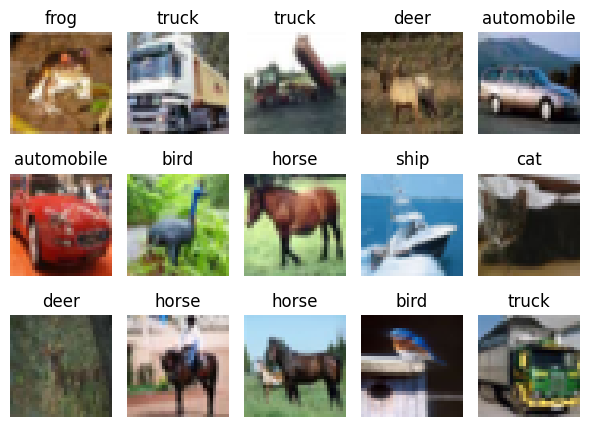

In [40]:
def image_gallery(n_rows=2):
    fig_width = 6
    fig_height = 3 * n_rows / 2
    fig, axs = plt.subplots(n_rows, 5, figsize=(fig_width, fig_height))
    axs = axs.flatten()

    for i in range(n_rows*5):
        img = trainset.data[i]
        axs[i].imshow(img)
        axs[i].set_title(trainset.classes[trainset.targets[i]])
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

image_gallery(3)

### Class Distribution

As expected based on the dataset's description, the CIFAR10 dataset includes 50'000 images for each class in the training dataset and is therefore balanced.

{6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000}


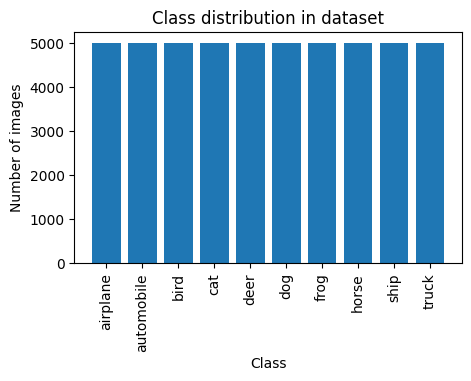

{3: 1000, 8: 1000, 0: 1000, 6: 1000, 1: 1000, 9: 1000, 5: 1000, 7: 1000, 4: 1000, 2: 1000}


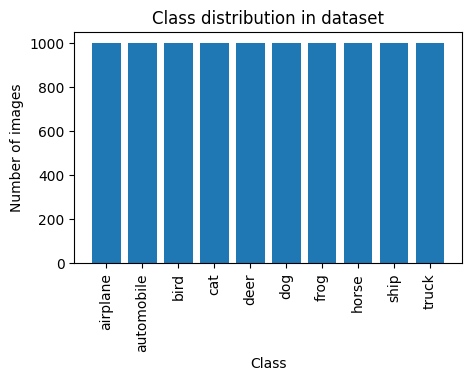

In [8]:
# Check the distribution of the classes in the training set
def show_class_distribution(dataset):
    class_count_dict = {}
    for i in range(len(dataset.targets)):
        if dataset.targets[i] in class_count_dict:
            class_count_dict[dataset.targets[i]] += 1
        else:
            class_count_dict[dataset.targets[i]] = 1
    for i in range(10):
        if i not in class_count_dict:
            class_count_dict[i] = 0

    print(class_count_dict)

    # plot bar plot with target labels
    plt.bar(range(len(class_count_dict)), list(class_count_dict.values()), align='center')
    plt.xticks(range(len(class_count_dict)), dataset.classes, rotation=90)
    plt.xlabel('Class')
    plt.ylabel('Number of images')
    plt.title('Class distribution in dataset')

    fig = plt.gcf()
    fig.set_size_inches(5, 3)

    plt.show()

show_class_distribution(trainset)
show_class_distribution(testset)

# Schritt 3: Aufbau Modellierung

Metriken zur Evaluierung:
- Accuracy
- F1-Score

1. Lege fest, wie (mit welchen Metriken) Du Modelle evaluieren möchtest. 
Berücksichtige auch den Fehler in der Schätzung dieser Metriken.  
2. Implementiere Basisfunktionalität, um Modelle zu trainieren und gegeneinander zu 
evaluieren.  
Empfehlenswert ist die Verwendung einer geeigneten MLOps Plattform (z.B. W&B) 
3. Teste Modelle und Trainingsfunktionalität, indem Du nur mit einem einzigen Sample 
oder einem Batch trainierst. Damit bekommst Du zwar Overfitting, aber auch einen 
guten Test, der zeigt dass Information aus den Daten aufgenommen werden kann.

Komplexität/Tiefe des Modells variieren

Bei CNN: Filter Grössen variieren

Hyperparameter -> Tuning reicht bei einem Modell

## Testen der Trainingsfunktionalität

Ich trainiere ein einfaches Modell nur einem Batch.

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import torchmetrics

class Simple_CNN(pl.LightningModule):
    """
    A simple convolutional neural network (CNN) for image classification tasks.
    """
    def __init__(self):
        super().__init__()

        # Initialize the network layers
        # @ Define the CNN architecture with a single convolutional layer, 3 input channels (RGB) and 16 output channels (filters)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1) # from dimension (batch_size, 3, H, W) to (batch_size, 16, H, W)

        # @ Using max-pooling layer to keep only the max value in each 2x2 (size=2) window of the 16 filters, moving 2 pixels at a time (stride=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # from dimension (batch_size, 16, H, W) to (batch_size, 16, H/2, W/2)

        # @ Fully connected output layer
        self.fc1 = nn.Linear(16 * 16 * 16, 10) # takes (batch_size, 16, H/2, W/2) to (batch_size, 10) for our classification task

        # Initialize metrics
        self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.precision = torchmetrics.Precision(task="multiclass", average=None, num_classes=10)
        self.recall = torchmetrics.Recall(task="multiclass", average=None, num_classes=10)
        self.f1 = torchmetrics.F1Score(task="multiclass", average=None, num_classes=10)

    def forward(self, x):
        """
        Forward pass through the CNN.

        Args:
            x (torch.Tensor): Input tensor with shape (batch_size, 3, 32, 32).

        Returns:
            torch.Tensor: Output tensor with shape (batch_size, 10).
        """
        x = self.pool(F.relu(self.conv1(x))) # ReLU activation function to introduce non-linearity
        x = x.view(-1, 16 * 16 * 16) # Flatten the output of the convolutional layer (-1 means that the batch size is inferred by PyTorch)
        x = self.fc1(x) # Fully connected output layer
        return x

    def configure_optimizers(self):
        """
        Set up the optimizer for the CNN.

        Returns:
            torch.optim.Optimizer: The optimizer for this model.
        """
        # Upddate model parameters using Adam, which combines the ideas of momentum and adaptive learning rates
        return torch.optim.Adam(self.parameters(), lr=1e-3) # self.parameters() returns current model params; lr is the initial learning rate 

    def training_step(self, batch, batch_idx):
        """
        Perform a single training step.

        Args:
            batch (tuple): A tuple containing the input and target tensors.
            batch_idx (int): The index of the current batch.

        Returns:
            torch.Tensor: The training loss for the current batch.
        """
        inputs, targets = batch
        outputs = self(inputs) # equivalent to self.forward(inputs)
        loss = F.cross_entropy(outputs, targets)
        preds = torch.argmax(outputs, dim=1)

        # Log training accuracy, precision, recall, and F1
        self.train_accuracy(preds, targets)
        self.log("train_accuracy", self.train_accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        self.precision(preds, targets)
        self.log("train_precision_per_class", self.precision, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_macro_precision", self.precision.compute_average(), on_step=True, on_epoch=True, prog_bar=True, logger=True)

        self.recall(preds, targets)
        self.log("train_recall_per_class", self.recall, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_macro_recall", self.recall.compute_average(), on_step=True, on_epoch=True, prog_bar=True, logger=True)

        self.f1(preds, targets)
        self.log("train_f1_per_class", self.f1, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_macro_f1", self.f1.compute_average(), on_step=True, on_epoch=True, prog_bar=True, logger=True)

        # Log training loss 
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        """
        Perform a single validation step.

        Args:
            batch (tuple): A tuple containing the input and target tensors.
            batch_idx (int): The index of the current batch.

        Returns:
            None
        """
        inputs, targets = batch
        outputs = self(inputs) # equivalent to self.forward(inputs)
        loss = F.cross_entropy(outputs, targets)
        preds = torch.argmax(outputs, dim=1)
        
        # Log validation accuracy, precision, recall, and F1
        self.val_accuracy(preds, targets)
        self.log("val_accuracy", self.val_accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        self.precision(preds, targets)
        self.log("val_precision_per_class", self.precision, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_macro_precision", self.precision.compute_average(), on_step=True, on_epoch=True, prog_bar=True, logger=True)

        self.recall(preds, targets)
        self.log("val_recall_per_class", self.recall, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_macro_recall", self.recall.compute_average(), on_step=True, on_epoch=True, prog_bar=True, logger=True)

        self.f1(preds, targets)
        self.log("val_f1_per_class", self.f1, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_macro_f1", self.f1.compute_average(), on_step=True, on_epoch=True, prog_bar=True, logger=True)

        # Log validation loss 
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

In [56]:
# Configure Weights & Biases sweeps
sweep_config = {
    "name": "simple-cnn-singlebatch",
    "method": "grid",
    "metric": {
        "name": "val_accuracy",
        "goal": "maximize",
    },
    "parameters": {
        "epochs": {"values": [10]},
    }
}

# Setup Weight & Biases
sweep_id = wandb.sweep(
    sweep_config, entity='yvokeller', project='deep-learning'
)

# Create the PyTorch Lightning Trainer
def train_sweep():
    wandb.init()

    model = Simple_CNN()

    trainer = li.Trainer(
        max_epochs=wandb.config.epochs,
        limit_train_batches=1,
        limit_val_batches=1,
        logger=WandbLogger(entity='yvokeller', project='deep-learning'),
        log_every_n_steps=1,
        enable_progress_bar=True,
        callbacks=[TQDMProgressBar(refresh_rate=10)] # update every 10 batches
    )

    train_dataloader, val_dataloader = get_dataloaders(batch_size=32)

    trainer.fit(model, train_dataloader, val_dataloader)
    wandb.finish()

# Run the sweep
wandb.agent(sweep_id, function=train_sweep)

Create sweep with ID: uhun75b5
Sweep URL: https://wandb.ai/yvokeller/deep-learning/sweeps/uhun75b5


wandb: Agent Starting Run: q58kfbfk with config:
wandb: 	epochs: 10


/opt/homebrew/Caskroom/miniforge/base/envs/deep-learning/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.


Run q58kfbfk errored: TypeError("get_dataloaders() missing 1 required positional argument: 'self'")
wandb: ERROR Run q58kfbfk errored: TypeError("get_dataloaders() missing 1 required positional argument: 'self'")
wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


## PyTorch Lightning

In [15]:
# Define the CNN architecture
class Random_CNN(li.LightningModule):
    def __init__(self, num_filters1=32, num_filters2=64, linear1_out=512, learning_rate=1e-3):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, num_filters1, kernel_size=(3,3), padding=1)
        self.conv2 = torch.nn.Conv2d(num_filters1, num_filters2, kernel_size=(3,3), padding=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.fc1 = torch.nn.Linear(num_filters2 * 8 * 8, linear1_out)
        self.fc2 = torch.nn.Linear(linear1_out, 10)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.5)
        self.learning_rate = learning_rate

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = torch.nn.CrossEntropyLoss()(outputs, targets)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = torch.nn.CrossEntropyLoss()(outputs, targets)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

In [8]:
# Configure Weights & Biases sweeps
sweep_config = {
    "name": "cnn-sweep-test",
    "method": "grid",
    "metric": {
        "name": "val_loss",
        "goal": "minimize",
    },
    "parameters": {
        "num_filters1": {"values": [4, 8, 16]},
        "num_filters2": {"values": [4, 8, 16]},
        "linear1_out": {"values": [256, 512, 1024]},
        "learning_rate": {"values": [1e-5, 1e-4, 1e-3]},
        "epochs": {"values": [10]},
    }
}

# Setup Weight & Biases
sweep_id = wandb.sweep(
    sweep_config, entity='yvokeller', project='deep-learning'
)

# Create the PyTorch Lightning Trainer
def train_sweep():
    wandb.init()

    model = Baseline_CNN(
        num_filters1=wandb.config.num_filters1,
        num_filters2=wandb.config.num_filters2,
        linear1_out=wandb.config.linear1_out,
        learning_rate=wandb.config.learning_rate,
    )

    trainer = li.Trainer(
        max_epochs=wandb.config.epochs,
        logger=WandbLogger(entity='yvokeller', project='deep-learning'),
        log_every_n_steps=1,
        enable_progress_bar=True,
        callbacks=[TQDMProgressBar(refresh_rate=10)]
        # progress_bar_refresh_rate=100,
    )

    trainer.fit(model, trainloader, testloader)
    wandb.finish()

# Run the sweep
wandb.agent(sweep_id, function=train_sweep)

Create sweep with ID: 6t2sc37f
Sweep URL: https://wandb.ai/yvokeller/deep-learning/sweeps/6t2sc37f


wandb: Agent Starting Run: 24knqwkf with config:
wandb: 	epochs: 10
wandb: 	learning_rate: 1e-05
wandb: 	linear1_out: 256
wandb: 	num_filters1: 4
wandb: 	num_filters2: 4
wandb: Currently logged in as: yvokeller. Use `wandb login --relogin` to force relogin


/opt/homebrew/Caskroom/miniforge/base/envs/deep-learning/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type      | Params
--------------------------------------
0 | conv1   | Conv2d    | 112   
1 | conv2   | Conv2d    | 148   
2 | pool    | MaxPool2d | 0     
3 | fc1     | Linear    | 65.8 K
4 | fc2     | Linear    | 2.6 K 
5 | relu    | ReLU      | 0     
6 | dropout | Dropout   | 0     
--------------------------------------
68.6 K    Trainable params
0         Non-trainable params
68.6 K    Total params
0.274     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

wandb: Ctrl + C detected. Stopping sweep.


wandb: Network error (ConnectionError), entering retry loop.


Validation: 0it [00:00, ?it/s]

# Schritt 4: Evaluation

### Testing the Model

#### Ground Truth

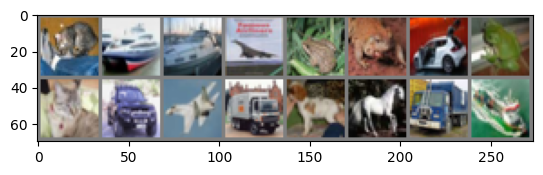

GroundTruth:  cat   ship  ship  plane


In [18]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

#### Model Prediction

In [20]:
MODEL_PATH = './cifar_net.pth'

net = Net()
net.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [21]:
# Predict
outputs = net(images)
outputs

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   car   ship  ship 
